#### Setting up the File

In [392]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Formatting API Request

We need the url of the website - which is clear from the website; we also have to specify the year - which is 2018 - and we need to specify the exact dataset we need, which is 'abstcb'. To change the dataset, we would change the tech_dataset variable. 

The tech_url is just combining these variables above together so we can properly call the API. 

Here, we want to grab the data that we need. We really just want the state name (NAME), ethnic group (ETH_GROUP), ethnic group label (ETH_GROUP_LABEL), employee count (EMP), and factors adversely affecting technology production(FACTORS_P), and motivation for technology use (MOTUSETECH). The tech predicates are the specifications of what we're looking for. The 'get' values are simply the columns that we need, the 'for' value clarifies that we're looking for the state information, not the United States per se. For this matter, we could theoretically use the US data because we don't absolutely need the states for this part, but it doesn't really matter. 

The tech_response is the actual request, the object returned when we call the API. 

In [393]:
tech_url = 'https://api.census.gov/data'
tech_year = '2018'
tech_dataset = 'abstcb' # CHANGE THIS TO CHANGE DATASET

tech_url = '/'.join([tech_url, tech_year, tech_dataset])

# FORMATTING API REQUEST

tech_predicates = {}
get_vars = ['NAME', 'ETH_GROUP', 'ETH_GROUP_LABEL', 'EMP', 'FACTORS_P', 'FACTORS_P_LABEL', 'MOTUSETECH'] # CHANGE THIS TO CHANGE VARIABLES RECEIVED
tech_predicates['get'] = ','.join(get_vars)
tech_predicates['for'] = 'state:*' # CHANGE THIS TO CHANGE GEOGRAPHIC SCOPE
tech_predicates['key'] = '7c2c8ae1aefce7823680175cfa25d0ba300fe6f5' # DON'T CHANGE THIS
tech_response = requests.get(tech_url, params=tech_predicates)


This part below is pretty simple; we're turning the request into a json object, then turning it into an object. Notice that the columns is the first value of the JSON object while the data is everything else. 

In [394]:
tech_json = tech_response.json()
tech_columns = tech_json[0]

tech_df = pd.DataFrame(columns = tech_columns, data = tech_json[1:])

Now we're getting into the really dirty work, but it's pretty simple after the first run; we're going to repeat the same process so the main explanation will take place here and we'll only explain any changes as they come up. 

First, let's fix up the tech_df object by cleaning it as we need. We don't want FACTORS_P_LABEL to have All firms, so we'll git rid of that. NextFor control sake, we will also only use data where ETH_GROUP_LABEL is total, as opposed to each group. We don't want this segmented further than it needs to be. 

Next, we need to transform the EMP column into an column full of integers so we can actually do a mean calculation on it. 

Finally, let's group the variable by FACTORS_P_LABEL and have it summarize EMP as mean, so we're getting the average EMP by FACTOR_P_LABEL. Notice that we include that "as_index = False" portion; this will help us later when we want to access only certain parts of the columns. Please include that. 

In [409]:
tech_df_fixed = tech_df[tech_df['FACTORS_P_LABEL'] != 'All firms']
tech_df_fixed = tech_df_fixed[tech_df_fixed['ETH_GROUP_LABEL'] == 'Total']
tech_df_fixed['EMP'] = tech_df_fixed['EMP'].astype('int32')
tech_df_factor_grouped = tech_df_fixed.groupby('FACTORS_P_LABEL', as_index = False)['EMP'].mean()

Now that we've grouped everything together, we want to focus on the AI portion of the data. We only want to grab the tech_df_AI[0:10] because that's the segment of the data that is only AI. Now that we've selected this data, we want to filter out what we don't need. Specifically, we don't want data that says the required data wasn't available, there were no factors adversely affecting the adoption of AI, and we finally we don't need any AI data where the technology is not applicable to the business. 

After that, we make our own variable that includes the FACTORS_P_LABEL column - past the words "Artificial Intelligence:", as that would be redundant. We want to replace a few of those values in that variable so it looks cleaner for the graph. We also make a variable that includes all of the EMP info. 

After that, it's very simple. Just use the variables that contain column data as the x and y values to build a horizontal bar graph, then add an x-label, y-label, and a title. That "ticklabel_format" line is there to get the data out of scientific notation. 

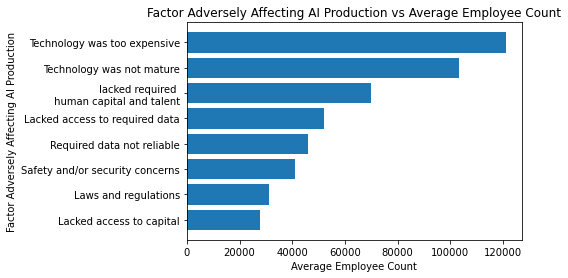

In [417]:
tech_df_AI = tech_df_factor_grouped[0:10]
tech_df_AI = tech_df_AI[tech_df_AI['FACTORS_P_LABEL'] != 'Artificial Intelligence: Technology not applicable to this business']
tech_df_AI = tech_df_AI[tech_df_AI['FACTORS_P_LABEL'] != 'Artificial Intelligence: No factors adversely affected the adoption of this technology']
tech_df_AI = tech_df_AI.sort_values(by = 'EMP', ascending = False)
factors_p_label = tech_df_AI['FACTORS_P_LABEL'].str[25:]
factors_p_label = factors_p_label.replace('Concerns regarding safety and security (physical security and/or cyber security)', 
'Safety and/or security concerns')
factors_p_label = factors_p_label.replace('Lacked access to required human capital and talent', 'lacked required \n human capital and talent')
emp_info = tech_df_AI['EMP']

tech_df_AI_plot = plt.barh(factors_p_label, emp_info)
tech_df_AI_plot = plt.xlabel('Average Employee Count')
tech_df_AI_plot = plt.ylabel('Factor Adversely Affecting AI Production')
tech_df_AI_plot = plt.ticklabel_format(style = 'plain', axis = 'x')
tech_df_AI_plot = plt.title('Factor Adversely Affecting AI Production vs Average Employee Count')
tech_df_AI_plot = plt.gca().invert_yaxis(); 

Repeat the same process as above, but with some modifications. The cleaning now is about robotics as opposed to AI, so the subsection of the grouped-data will be 22:32, and we only need the string past 10 for the FACTORS_P_LABEL column, cutting out the word "robotics:". Change the variable names to match robotics, and everything else should be very similar. 

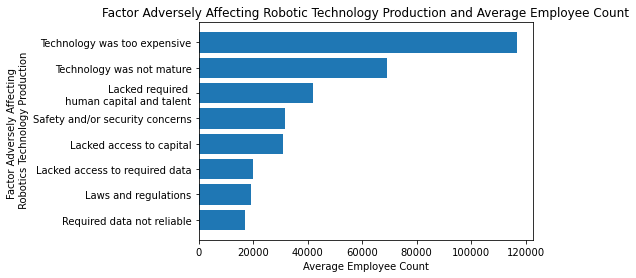

In [415]:
tech_df_robotics = tech_df_factor_grouped[22:32]
tech_df_robotics = tech_df_robotics[tech_df_robotics['FACTORS_P_LABEL'] != 'Robotics: Technology not applicable to this business']
tech_df_robotics = tech_df_robotics[tech_df_robotics['FACTORS_P_LABEL'] != 'Robotics: No factors adversely affected the adoption of this technology']
tech_df_robotics = tech_df_robotics.sort_values(by = 'EMP', ascending = False)
factors_p_label_robotics = tech_df_robotics['FACTORS_P_LABEL'].str[10:]
factors_p_label_robotics = factors_p_label_robotics.replace('Concerns regarding safety and security (physical security and/or cyber security)', 
'Safety and/or security concerns')
factors_p_label_robotics = factors_p_label_robotics.replace('Lacked access to required human capital and talent', 'Lacked required \n human capital and talent')
robotics_emp_info = tech_df_robotics['EMP']

tech_df_robotics_plot = plt.barh(factors_p_label_robotics, robotics_emp_info)
tech_df_robotics_plot = plt.xlabel('Average Employee Count')
tech_df_robotics_plot = plt.ylabel('Factor Adversely Affecting \n Robotics Technology Production')
tech_df_robotics_plot = plt.title('Factor Adversely Affecting Robotic Technology Production and Average Employee Count')
tech_df_robotics_plot = plt.ticklabel_format(style = 'plain', axis = 'x')
tech_df_robotics_plot = plt.gca().invert_yaxis()

Now we're onto working with the MOTUSETECH data, which covers the motivation for having certain technology. As the documentation for the data shows, the first two characters of the "MOTUSETECH" column clarify the type of technology. In this case, T4 is robot technology, so we only want data where the first two characters of MOTUSETECH is T4. Next, we want to control the ETH_GROUP_LABEL so it only includes "Total" as opposed to segmenting by ethnicity group. As before, we want to change the EMP column into a column with integers. Finally, we group the data by MOTUSETECH, summarizing the EMP data by mean. We also have the "as_index = False" parameter so we can work with the data more easily. 

In [424]:
tech_df_motusetech_robot = tech_df[tech_df['MOTUSETECH'].str[0:2] == 'T4']
tech_df_motusetech_robot = tech_df_motusetech_robot[tech_df_motusetech_robot['ETH_GROUP_LABEL'] == 'Total']
tech_df_motusetech_robot['EMP'] = tech_df_motusetech_robot['EMP'].astype('int32')
tech_df_motusetech_robot_grouped = tech_df_motusetech_robot.groupby('MOTUSETECH', as_index = False)['EMP'].mean()
tech_df_motusetech_robot_grouped = tech_df_motusetech_robot_grouped.sort_values(by = 'EMP', ascending = True)

First, we only need the data from 0:6 because the final value is the total; store that in a new variable so we can later use it in the plot. From there, we just want to change the names of the data to match the data labels, as to not confuse the reader. 

Do the same with the EMP column, but don't change any of the data. 

From there, plot the graph with the following specified: xlabel, ylabel, and title. Also specify the color so it doesn't come out multi-colored. 

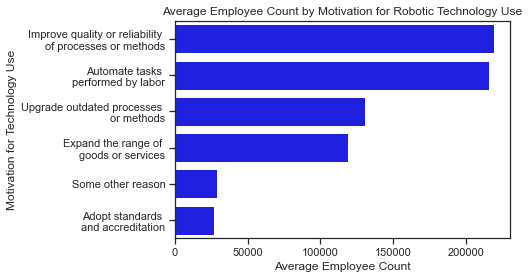

In [429]:
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_grouped['MOTUSETECH'][0:6]
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_reason.replace('T4E13C01', 'Automate tasks \n performed by labor')
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_reason.replace('T4E13C02', 'Upgrade outdated processes \n or methods')
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_reason.replace('T4E13C03', 'Improve quality or reliability \n of processes or methods')
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_reason.replace('T4E13C04', 'Expand the range of \n goods or services')
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_reason.replace('T4E13C05', 'Adopt standards \n and accreditation')
tech_df_motusetech_robot_reason = tech_df_motusetech_robot_reason.replace('T4E13C06', 'Some other reason')

tech_df_robot_emp = tech_df_motusetech_robot_grouped['EMP'][0:6]
tech_df_robot_emp

tech_df_motusetech_plot = sns.barplot(x = tech_df_robot_emp, y = tech_df_motusetech_robot_reason, color = 'Blue').set(xlabel = 'Average Employee Count',
ylabel = 'Motivation for Technology Use',
title = 'Average Employee Count by Motivation for Robotic Technology Use')
tech_df_motusetech_plot = plt.gca().invert_yaxis(); 

Now we're going to create the AI data. Do everything the same as when creating the robot data, but change it so the data found has 'T1' as the two first characters and name the variables as AI rather than robot. 

In [426]:
tech_df_motusetech_ai = tech_df[tech_df['MOTUSETECH'].str[0:2] == 'T1']
tech_df_motusetech_ai = tech_df_motusetech_ai[tech_df_motusetech_ai['ETH_GROUP_LABEL'] == 'Total']
tech_df_motusetech_ai['EMP'] = tech_df_motusetech_ai['EMP'].astype('int32')
tech_df_motusetech_ai_grouped = tech_df_motusetech_ai.groupby('MOTUSETECH', as_index = False)['EMP'].mean()
tech_df_motusetech_ai_grouped = tech_df_motusetech_ai_grouped.sort_values(by = 'EMP', ascending = False)

Again, do the same as everything in the robot data, but change it to match the AI data. It's almost all the same. 

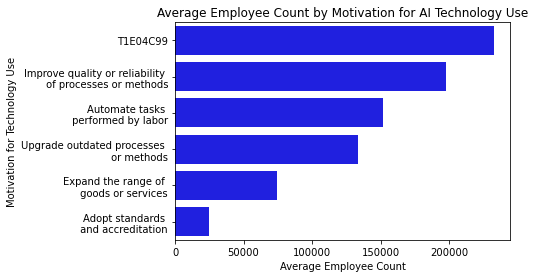

In [427]:
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_grouped['MOTUSETECH'][0:6]
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_reason.replace('T1E04C01', 'Automate tasks \n performed by labor')
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_reason.replace('T1E04C02', 'Upgrade outdated processes \n or methods')
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_reason.replace('T1E04C03', 'Improve quality or reliability \n of processes or methods')
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_reason.replace('T1E04C04', 'Expand the range of \n goods or services')
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_reason.replace('T1E04C05', 'Adopt standards \n and accreditation')
tech_df_motusetech_ai_reason = tech_df_motusetech_ai_reason.replace('T1E04C06', 'Some other reason')

tech_df_robot_emp = tech_df_motusetech_ai_grouped['EMP'][0:6]
tech_df_robot_emp

sns.barplot(x = tech_df_robot_emp, y = tech_df_motusetech_ai_reason, color = 'Blue').set(xlabel = 'Average Employee Count',
ylabel = 'Motivation for Technology Use',
title = 'Average Employee Count by Motivation for AI Technology Use'); 